# Out-of-sample Embedding

Imagine you have a citation network of scholars publishing papers. The nodes are the scholars, and an edge exists in a given pair of scholars if they're published a paper together.

You've already found a representation using ASE or LSE and you have a set of latent positions, which you then clustered to figure out who came from which university. It took a long time for you to get this representation - there are a lot of people doing research out there!

Now, suppose a new graduate student publishes a paper. Your network gets bigger by a single node, and you'd like to find this person's latent position (thus adding them to the clustering system). To do that, however, you'd have to get an entirely new representation for the network: your latent position matrix is $n \times d$, and it would need to become $(n+1) \times d$. Re-embedding the entire network with the new node added seems like it should be unecessary - after all, you already know the latent positions for every other node.

This section is all about this problem: how to find the representation for new nodes without the computationally expensive task of re-embedding an entire network. As it turns out, there has been some work done, and there is a solution that can get you pretty close the latent position for the new node that you would have had. For more details and formaility, see the 2013 paper "Out-of-sample extension for latent position graphs", by Tang et al (although, as with most science, the theory in this paper was built on top of other work from related fields).

Let's make a network from an SBM, and an additional node that should belong to the first community. Then, we'll embed the network and explore how to find the latent position for the additional node. 

## Data Generation

In [1]:
import numpy as np
from graspologic.simulations import sbm
from graspologic.utils import remove_vertices

# Generate parameters
B = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate both an original network along with community memberships, 
# and an out-of-sample node with the same SBM call
network, labels = sbm(n=[101, 100], p=B, return_labels=True)
labels = list(labels)

# Grab out-of-sample node
oos_idx = 0
oos_label = labels.pop(oos_idx)

# create our original network
A, a_1 = remove_vertices(network, indices=oos_idx, return_removed=True)

What we have now is a network and an additional node. You can see the adjacency matrix for the network below, along with the adjacency vector for the additional node (Here, an “adjacency vector”  is a vector with a 1 in every position that the out-of-sample node has an edge with an in-sample node). The heatmap on the left is a network with two communities, with 100 nodes in each community. The vector on the right is purple on row $i$ if the $i^{th}$ in-sample node is connected to the out-of-sample node.

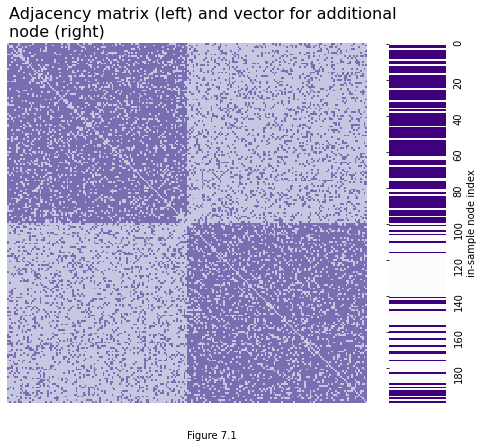

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from graphbook_code import heatmap
from graphbook_code.plotting import cmaps

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])

# heatmap
heatmap(A, ax=ax, cbar=False)

# adjacency vector
ax = fig.add_axes([.85, 0, .1, 1])
cmap = cmaps["sequential"]
plot = sns.heatmap(a_1[:, np.newaxis], ax=ax, cbar=False, cmap=cmap, xticklabels=False, yticklabels=20)
plt.tick_params(axis='y', labelsize=10, labelleft=False, labelright=True)
plt.ylabel("in-sample node index")
plot.yaxis.set_label_position("right")

# title
fig.suptitle("Adjacency matrix (left) and vector for additional \nnode (right)", y=1.1, fontsize=16, x=.19, ha="left");
plt.figtext(0.5, -.1, "Figure 7.1")
plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_7-1.png", dpi=300, transparent=False, bbox_inches='tight')

After embedding with ASE, we have an embedding for the original network. The rows of this embedding contain the latent position for each original node. We'll call the embedding $X$.

In [3]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

ase = ASE(n_components=2)
ase.fit(A)
X = ase.transform(A)

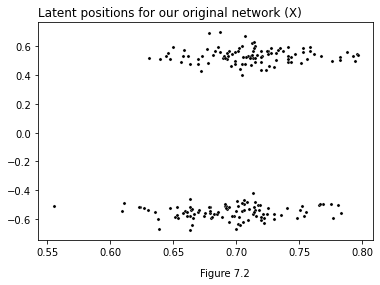

In [4]:
from graphbook_code import plot_latents
plot_latents(X, title="Latent positions for our original network (X)");
plt.figtext(0.5, 0, "Figure 7.2")
plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_7-2.png", dpi=300, transparent=False, bbox_inches='tight')

## Probability Vector Estimation

Everything up until now has just been pretty standard stuff. We still haven't done anything with our new node - all we have is a big vector that tells us which other nodes it's connected to, and our standard matrix of latent positions. However, it's time for a bit more exploration into the nature of the latent position matrix $X$, and what happens when you view it as a linear transformation. This will get us closer to understanding the out-of-sample embedding.

Remember from the section on latent positions that $X$ can be used to estimate the block probability matrix. When you use ASE on a single network to make $X$, $XX^\top$ estimates $P$: meaning, $(XX^\top)_{ij}$, the element on the $i^{(th)}$ row and $j^{(th)}$ column of $XX^\top$, will estimate the probability that node $i$ has an edge with node $j$.

Let's take a single latent position vector - call it $v_i$ (this will be the $i_{th}$ row of the latent position matrix). What'll $X v_i$ look like? Well, it'll look the same as grabbing the $i_{th}$ column of $XX^\top$. Meaning, $X v_i$ will be a single vector whose $j^{(th)}$ element estimates the probability that node $i$ will connect to node $j$.

You can see this in action below. We took the latent position corresponding to the first node out of the latent position matrix (and called it $v_1$), and then multiplied it by the latent position matrix itself. What emerged is what you see below: a vector that shows the estimated probability that node 0 has an edge with each other node in the network. The true probabilities for the first half of nodes (the ones in the same community) should be .8, and the true probabilities for the second half of nodes in the other community should be .2. The average values were .775 and .149 - so, pretty close!

In [5]:
v_1 = X[0, :]
v_est_proba = X @ v_1

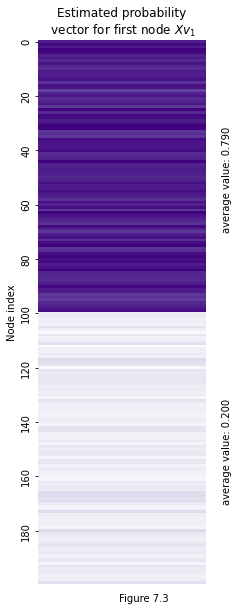

In [6]:
fig, ax = plt.subplots(figsize=(3, 10))
sns.heatmap(v_est_proba[:, np.newaxis], cbar=False, cmap=cmap, xticklabels=False, yticklabels=20, ax=ax)
ax.text(1.1, 70, s=f"average value: {v_est_proba[:100].mean():.3f}", rotation=90)
ax.text(1.1, 170, s=f"average value: {v_est_proba[100:].mean():.3f}", rotation=90)
ax.set_ylabel("Node index")

plt.title("Estimated probability\n vector" + r" for first node $X v_1$");

plt.figtext(0.5, 0.1, "Figure 7.3")
plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_7-3.png", dpi=300, transparent=False, bbox_inches='tight')

## Inversion of Probability Vector Estimation

Remember that our goal is to take the adjacency vector for a new node and use it to estimate that node's latent position without re-embedding the whole network. So far, we've essentially figured out how to use the node's latent position to get an estimated probability vector.

Let's think about the term "estimated probability vector" for a second. This should be a vector associated to node $i$ with $n$ elements, where the $j^{(th)}$ element of the vector contains the probability that node $i$ will connect to node $j$. The thing we're starting with for the out-of-sample node, however, is an adjacency vector full of 0's and 1's - 0 if there isn't an edge, 1 if there is an edge.

If you think about it, however, you can think of this adjacency vector as kind of an estimate for edge probabilities. Say you sample a node's adjacency vector from an RDPG, then you sample again, and again. Averaging all of your samples will get you closer and closer to the actual edge connection probabilities. So you can think of a single adjacency vector as an estimate for the edge probability vector!

The point here is that if you can start with a latent position and then estimate the edge probabilities, it's somewhat equivalent (albeit going in the other direction) to start with an out-of-sample adjacency vector and estimate a node's the latent position.

Let's call the estimated probability vector $\hat{a_i}$. We know that $\hat{a_i} = \hat{X} \hat{v_i}$: you multiply the latent position matrix by the $i_{th}$ latent position to estimate the probability vector (remember that the ^ hats above letters means we're getting an estimate for something, rather than getting the thing itself). How do we isolate the latent position $\hat{v_i}$?

Well, if $X$ were invertible, we could do $\hat{X}^{-1} \hat{a_i} = \hat{v_i}$: just invert both sides of the equation to get $v_i$ by itself. Unfortunately, in practice, $X$ will almost never be invertible. We'll have to do the next-best thing, which is to use the *pseudoinverse*.

We'll take a brief break in the coming section to talk about the pseudoinverse for a bit, then we'll come back and use it to estimate the out-of-sample latent position.

## The Moore-Penrose Pseudoinverse

The Moore-Penrose Pseudoinverse is useful to know in general, since it pops up a lot in a lot of different places. Say you have a matrix which isn't invertible. Call it $T$.

The pseudoinverse $T^+$ is the closest approximation you can get to the inverse $T^{-1}$. This is best understood visually. Let's take $T$ to be a matrix which projects points on the x-y coordinate axis down to the x-axis, then flips them to their negative on the number line. The matrix would look like this:

\begin{align*}
    T &=
    \begin{bmatrix}
    -1 & 0 \\
    0 & 0  \\
    \end{bmatrix}
\end{align*}

Some information is inherently lost here. Because the second column is all zeroes, any information in the y-axis can't be recovered. For instance, say we have some vectors with different x-axis and y-axis coordinates:
\begin{align*}
    v_1 &= \begin{bmatrix} 1 & 1 \end{bmatrix}^\top \\
    v_2 &= \begin{bmatrix} 2 & 2 \end{bmatrix}^\top
\end{align*}

When we use $T$ as a linear transformation to act on $v_1$ and $v_2$, the y-axis coordinates both collapse to the same thing (0, in this case). Information in the x-axis, however, is preserved.

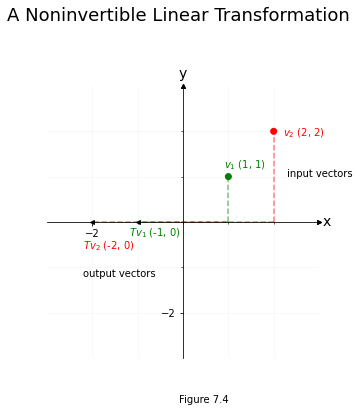

In [7]:
import numpy as np                 # v 1.19.2
import matplotlib.pyplot as plt    # v 3.3.2
from graphbook_code import draw_cartesian


# make axis
ax = draw_cartesian()

# Enter x and y coordinates of points and colors
xs = [1, 2]
ys = [1, 2]
colors = ['g', 'r']

# Plot points
ax.scatter(xs, ys, c=colors)

# Draw lines connecting points to axes
for x, y, c in zip(xs, ys, colors):
    ax.plot([x, x], [0, y], c=c, ls='--', lw=1.5, alpha=0.5)
    ax.plot([x, -x], [0, 0], c=c, ls='--', lw=1.5, alpha=0.5)


# Draw arrows
arrow_fmt = dict(markersize=4, color='black', clip_on=False)
ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

arrow_fmt = dict(markersize=4, color='black', clip_on=False)
ax.plot((-1), (0), marker='<', **arrow_fmt)
ax.plot((-2), (0), marker='<', **arrow_fmt)

# Draw text
ax.text(x=.9, y=1.2, s="$v_1$ (1, 1)", fontdict=dict(c="green"))
ax.text(x=2.2, y=1.9, s="$v_2$ (2, 2)", fontdict=dict(c="red"))

ax.text(x=-1.2, y=-.3, s="$T v_1$ (-1, 0)", fontdict=dict(c="green"))
ax.text(x=-2.2, y=-.6, s="$T v_2$ (-2, 0)", fontdict=dict(c="red"));

# input/output
ax.text(x=2.3, y=1, s="input vectors", fontdict=dict(c="black"))
ax.text(x=-2.2, y=-1.2, s="output vectors", fontdict=dict(c="black"));

plt.suptitle("A Noninvertible Linear Transformation", fontsize=18, y=1.1)
plt.figtext(0.5, 0, "Figure 7.4")
plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_7-4.png", dpi=300, transparent=False, bbox_inches='tight')

Our goal is to reverse $T$ and bring $Tv_1$ and $Tv_2$ back to $v_1$ and $v_2$. Unfortunately, since both $v_1$ and $v_2$ get squished onto zero in the y-axis position after getting passed through $T$, we've lost all information about what was happening on the y-axis -- that's a lost cause. So it's impossible to get perfectly back to $v_1$ or $v_2$.

If you restrict your attention to the x-axis, however, you'll see that $Tv_1$ and $Tv_2$ landed in different places ($v_1$ went to -1, and $v_2$ went to -2). You can use this information about the x-axis location of $Tv_1$ and $Tv_2$ to re-orient the x-axis values back to where they were prior to the vectors getting passed through X, even if it's impossible to figure out where the y-values were.

That's what the pseudoinverse does: it reverses what it can, and accepts that some information has vanished.

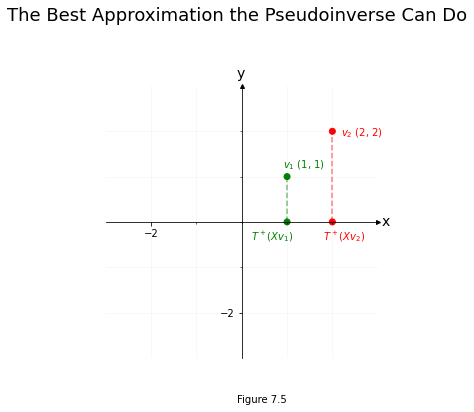

In [8]:
import numpy as np                 # v 1.19.2
import matplotlib.pyplot as plt    # v 3.3.2

# make axis
ax = draw_cartesian()

# Enter x and y coordinates of points and colors
xs = [1, 2]
ys = [1, 2]
xs_out = [1, 2]
ys_out = [0, 0]
colors = ['g', 'r']


# Plot points
ax.scatter(xs, ys, c=colors)
ax.scatter(xs_out, ys_out, c=colors)

# Draw lines connecting points to axes
for x, y, c in zip(xs, ys, colors):
    ax.plot([x, x], [0, y], c=c, ls='--', lw=1.5, alpha=0.5)

arrow_fmt = dict(markersize=4, color='black', clip_on=False)

# Draw text
ax.text(x=.9, y=1.2, s="$v_1$ (1, 1)", fontdict=dict(c="green"))
ax.text(x=2.2, y=1.9, s="$v_2$ (2, 2)", fontdict=dict(c="red"))

ax.text(x=.2, y=-.4, s="$T^+ (X v_1$)", fontdict=dict(c="green"))
ax.text(x=1.8, y=-.4, s="$T^+ (X v_2$)", fontdict=dict(c="red"));

plt.suptitle("The Best Approximation the Pseudoinverse Can Do", fontsize=18, y=1.1)
plt.figtext(0.5, 0, "Figure 7.5")
plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_7-5.png", dpi=300, transparent=False, bbox_inches='tight')

## Using the Pseudoinverse for Out-of-Sample Estimation

Let's get back to estimating our out-of-sample latent position.

Remember that we had a nonsquare latent position matrix $X$. Like we learned before, we can get the probability vector $a_i$ (the vector with its probability of connecting with node $j$ in the $j_{th}$ position) for a node by passing its latent position ($v_i$) through the latent position matrix.

\begin{align*}
a_i = X v_i
\end{align*}

We can think of $X$ as a matrix the same way we thought of $T$: it's a linear transformation that eats a vector, and doesn't necessarily preserve all the information about that vector when it outputs something (In this case, since $X$ brings lower-dimensional latent positions to higher-dimensional probability vectors, what's happening is more of a restriction on which high-dimensional vectors you can access than a loss of information, but that's not particularly important).

The pseudoinverse, $X^+$, is the best we can do to bring a higher-dimensional adjacency vector to a lower-dimensional latent position. Since the adjacency vector just approximates the probability vector, we can call it $\hat{a_i}$. In practice, the best we can do generally turns out to be a pretty good guess, and so we can get a decent estimation of the latent position $v_i$.

\begin{align*}
X^+ \hat{a_i} \approx X^+ (X v_i) \approx v_i
\end{align*}

Let's see it in action. Remember that we already grabbed our out-of-sample latent position and called it `a_1`. We use numpy's pseudoinverse function to generate the pseudoinverse of the latent position matrix. Finally, we use it to get `a_1`'s estimated latent position, and call it `v_1`. You can see the location of this estimate in Euclidean space below: it falls squarely into the first community, which is where it should be.

In [9]:
from numpy.linalg import pinv

# Make the pseudoinverse of the latent position matrix
X_pinverse = pinv(X)

# Get its estimated latent position
v_1 = X_pinverse @ a_1

In [10]:
v_1

array([0.72925811, 0.48484367])

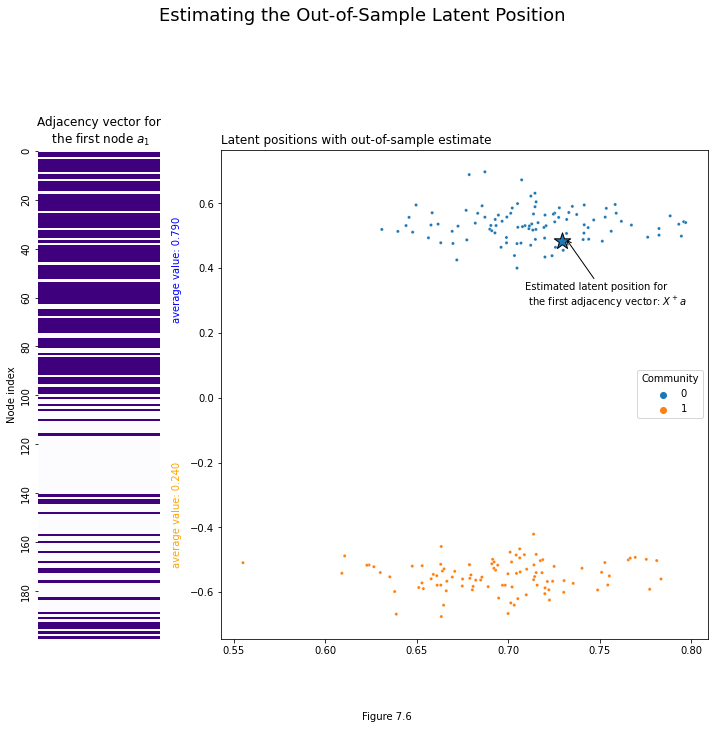

In [11]:
import matplotlib.gridspec as gridspec
np.random.seed(1)

# setup
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(3, 4)

# adjacency vector
ax = fig.add_subplot(gs[:, 0])
sns.heatmap(a_1[:, np.newaxis], cbar=False, cmap=cmap, xticklabels=False, yticklabels=20, ax=ax)
ax.text(1.1, 70, s=f"average value: {a_1[:100].mean():.3f}", rotation=90, c="blue")
ax.text(1.1, 170, s=f"average value: {a_1[100:].mean():.3f}", rotation=90, c="orange")
ax.set_ylabel("Node index")
ax.set_title(r"Adjacency vector for" + "\n" + " the first node $a_1$");

# latent position plot
ax = fig.add_subplot(gs[:, 1:])
plot = plot_latents(X, ax=ax, labels=labels, title="Latent positions with out-of-sample estimate")
plot.scatter(x=v_1[0], y=v_1[1], marker='*', s=300, edgecolor="black")
plot.annotate(r"Estimated latent position for" + "\n" + " the first adjacency vector: $X^+ a$", xy=(v_1[0]+.002, v_1[1]+.008), 
            xytext=(v_1[0]-.02, v_1[1]-.2), arrowprops={"arrowstyle": "->", "color": "k"})
sns.move_legend(ax, "center right")
fig.subplots_adjust(wspace=.5)

plt.suptitle("Estimating the Out-of-Sample Latent Position", fontsize=18, y=1.1)
plt.figtext(0.5, 0, "Figure 7.6")
plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_7-6.png", dpi=300, transparent=False, bbox_inches='tight')

## Using Graspologic

Of course, you don't have to do all of this manually. Below we generate an adjacency matrix $A$ from an SBM, as well as the adjacency vector for an out-of-sample node $a_1$. Once we fit an instance of the ASE class, the latent position for any new nodes can be predicted by simply calling `ase.transform` on the new adjacency vectors. 

You can do the same thing with multiple out-of-sample nodes if you want by stacking their adjacency vectors on top of each other in a numpy array, then transforming the whole stack.

In [12]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

# Generate parameters
B = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate a network along with community memberships
network, labels = sbm(n=[101, 100], p=B, return_labels=True)
labels = list(labels)

# Grab out-of-sample vertex
oos_idx = 0
oos_label = labels.pop(oos_idx)
A, a_1 = remove_vertices(network, indices=oos_idx, return_removed=True)

# Make an ASE model
ase = ASE(n_components=2)
X = ase.fit_transform(A)

# Predict out-of-sample latent positions by transforming
v_1 = ase.transform(a_1)

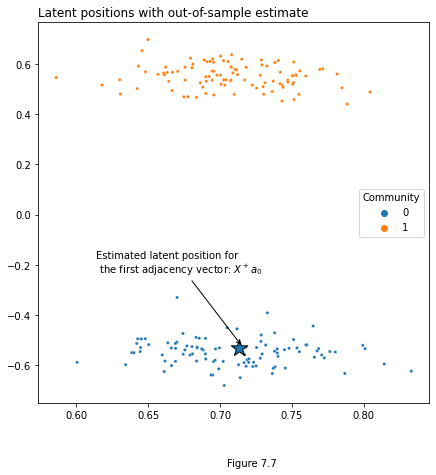

In [13]:
fig, ax = plt.subplots(figsize=(7,7))

# latent position plot
plot = plot_latents(X, ax=ax, labels=labels, title="Latent positions with out-of-sample estimate")
plot.scatter(x=v_1[0], y=v_1[1], marker='*', s=300, edgecolor="black")
plot.annotate(r"Estimated latent position for" + "\n" + " the first adjacency vector: $X^+ a_0$", xy=(v_1[0]+.002, v_1[1]+.008), 
            xytext=(v_1[0]-.1, v_1[1]+.3), arrowprops={"arrowstyle": "->", "color": "k"})
sns.move_legend(ax, "center right")
fig.subplots_adjust(wspace=.5)

plt.figtext(0.5, 0, "Figure 7.7")
plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_7-7.png", dpi=300, transparent=False, bbox_inches='tight')